(1171, 200, 200, 3)


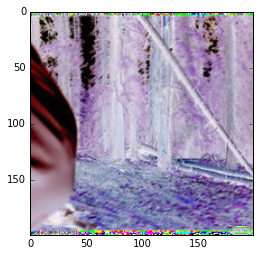

In [122]:

'''Trains a simple convnet on the sorted Denver Zoo dataset.
Gets to 75% test accuracy after only 3 epochs
(there is still a lot of margin for parameter tuning).
Relatively slow on CPU only machine, around 10min to complete 3 epochs.

Author: Qi Liu
'''

from __future__ import print_function
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

# image loading
import os
from PIL import Image                                                                                                                        
import matplotlib.pyplot as plt                                                  
import glob

%matplotlib inline

# training parameters
batch_size = 20 #128
nb_classes = 3 #10
nb_epoch = 3

# input image dimensions
img_rows, img_cols = 200, 200
color_dim = 3
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (4, 4)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

dpath = '/home/mirabot/Documents/deeplearning/zoophoto/zoosorted/mixed_resize/'
labelpath = '/home/mirabot/Documents/deeplearning/zoophoto/zoosorted/label.csv'

imagePath = sorted(glob.glob(dpath+'*.JPG'),key=numericalSort)
im_array = np.array( [np.array(Image.open(imagePath[i]).convert('RGB'), 'f') for i in range(len(imagePath))])

print (im_array.shape)

# read in groundtruth label
label = np.genfromtxt(labelpath, dtype=float, delimiter=',', names=True) 

np.random.seed(0)# for consistency

image_n = label.size
ratio = 0.85 # percentage of training data
train_id = np.random.choice(image_n, size=(int(image_n*ratio), 1), replace=False)

image_id = np.linspace(0, image_n-1, num=image_n, endpoint=True, dtype='int')
test_id = np.setdiff1d(image_id,train_id)

# training and testing data set
X_train = im_array[train_id,:,:,:]
Y_train = label[train_id]

X_test = im_array[test_id,:,:,:]
Y_test = label[test_id]

plt.imshow(im_array[883,:,:,:],cmap="gray")

In [123]:
"""TO-DO: Random sample training and testing sets with labels, make radom seed consistent
Then train 1 image to test, see how much time, then train 80% of the data sets
Then save model weights to h5
Make this procedure automatic"""

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], color_dim, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], color_dim, img_rows, img_cols)
    input_shape = (color_dim, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, color_dim)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, color_dim)
    input_shape = (img_rows, img_cols, color_dim)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

input_shape

# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(Y_train, nb_classes)
#Y_test = np_utils.to_categorical(Y_test, nb_classes)

X_train shape: (995, 3, 200, 200)
995 train samples
176 test samples


(3, 200, 200)

In [124]:
# timing profile
import timeit
start_time = timeit.default_timer()

# do things below

# build and train model
model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Convolution2D(nb_filters,kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# end of things, profile
# code you want to evaluate
elapsed = timeit.default_timer() - start_time
print ("Elapsed time: %s s." % (elapsed))

Train on 995 samples, validate on 176 samples
Epoch 1/3
995/995 [==============================] - 203s - loss: 1.0598 - acc: 0.4442 - val_loss: 0.9275 - val_acc: 0.4943
Epoch 2/3
995/995 [==============================] - 198s - loss: 0.9249 - acc: 0.5638 - val_loss: 0.8605 - val_acc: 0.6705
Epoch 3/3
995/995 [==============================] - 260s - loss: 0.7764 - acc: 0.6412 - val_loss: 0.7590 - val_acc: 0.6307
Test score: 0.759002864361
Test accuracy: 0.630681818182
Elapsed time: 682.483203173 s.


In [126]:
classes = model.predict_classes(X_test, batch_size=10)

176/176 [==============================] - 11s    


In [133]:
print (Y_test)
print (classes)

[(0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,)
 (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,)
 (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,)
 (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,)
 (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,) (0.0,)
 (0.0,) (0.0,) (0.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,) (1.0,)
 (1.0,) (2.0,) (2.0,) (2.0,) (2.0,) (2.0,) (2.0,) (2.0,) (2.0,) (2.0,)
 (2.0,

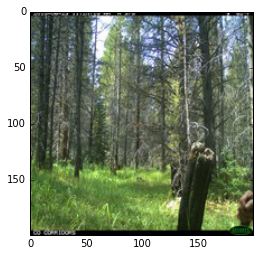

In [145]:
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, color_dim)
plt.imshow(X_test[175])

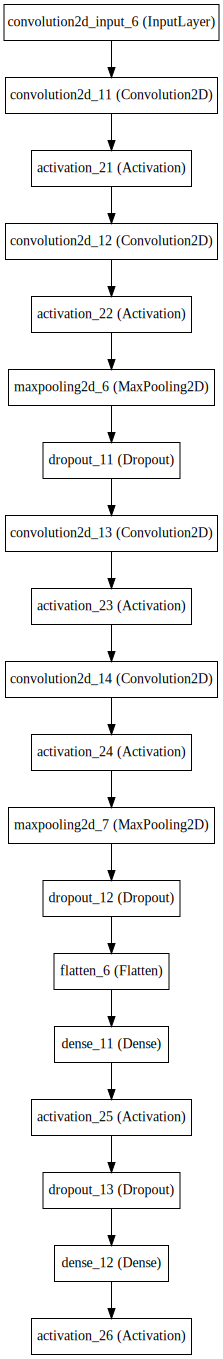

In [125]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))